# Book Review Sentiment Analysis
_Final Project — Cornell Tech Machine Learning Foundations_

**Last updated:** 2025-10-01

This notebook demonstrates the full ML lifecycle for an NLP classification task:
**problem definition → EDA → preprocessing → modeling → evaluation → comparison → takeaway**.

> **Goal:** Predict whether a book review is **positive** or **negative** from raw text.


## 1. Project Overview

- **Problem type:** Supervised **binary classification** (text sentiment).
- **Business value:** Real-time monitoring of customer feedback can alert product teams and
  support to reputation risks and highlight strengths that drive retention.
- **Input features:** Raw review text → cleaned and vectorized via **TF‑IDF**.
- **Label:** `PositiveReview` (1 = positive, 0 = negative).
- **Models compared:** Logistic Regression (with hyperparameter search) vs. a simple Keras Feedforward Network.
- **Key metrics:** Accuracy, Precision, Recall, F1, and Confusion Matrix.


## 2. Setup & Data

> 🗂️ **Dataset options:**  
> - If you have the course dataset, set `DATA_PATH` to that CSV.  
> - Otherwise, place a CSV named `book_reviews.csv` with columns `Review` and `PositiveReview` in the project root.

**Environment**: Python 3.x, pandas, numpy, scikit-learn, matplotlib, tensorflow (for the NN baseline).


In [2]:
%pip install tensorflow

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl (331.9 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\Python312\\Lib\\site-packages\\tensorflow\\python\\feature_column\\feature_column_lib.py'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import os
import re
import numpy as np
import pandas as pd
from typing import Tuple

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---- Data path handling ----
DATA_PATH = os.environ.get("../data/bookReviewsData.csv", None)
if DATA_PATH is None:
    # fallback to a conventional filename
    DATA_PATH = "../data/bookReviewsData.csv"

if not os.path.exists(DATA_PATH):
    print(f"[INFO] Expected dataset at '{DATA_PATH}'.")
    print("Provide a CSV with columns 'Review' (text) and 'PositiveReview' (0/1).")
else:
    print(f"[OK] Using dataset at: {DATA_PATH}")


[OK] Using dataset at: ../data/bookReviewsData.csv


## 3. Data Summary

We load the dataset, check for missing values, basic distributions, and review lengths.


In [11]:
# Load data
df = pd.read_csv(DATA_PATH)

# Basic checks
display(df.head())
display(df.info())
display(df['Positive Review'].value_counts())

# Text length distribution (simple numeric summary)
df['text_len'] = df['Review'].astype(str).apply(len)
print(df['text_len'].describe())


,Review,Positive Review
0,This was perhaps the best of Johannes Steinhof...,True
1,This very fascinating book is a story written ...,True
2,The four tales in this collection are beautifu...,True
3,The book contained more profanity than I expec...,False
4,We have now entered a second time of deep conc...,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1973 entries, 0 to 1972
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review           1973 non-null   object
 1   Positive Review  1973 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 17.5+ KB


None

Positive Review
False    993
True     980
Name: count, dtype: int64

count     1973.000000
mean       933.336036
std       1450.187183
min         59.000000
25%        331.000000
50%        586.000000
75%       1065.000000
max      32467.000000
Name: text_len, dtype: float64


## 4. Text Preprocessing

We apply a minimal, reproducible cleaning function:
- Lowercasing
- Remove URLs
- Remove non-alphabetic characters
- Collapse extra whitespace


In [12]:
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)              # remove URLs
    s = re.sub(r"[^a-z\s]", " ", s)                      # keep letters and spaces
    s = re.sub(r"\s+", " ", s).strip()                   # collapse spaces
    return s

df['cleaned_review'] = df['Review'].astype(str).apply(clean_text)
display(df[['Review', 'cleaned_review']].head())


,Review,cleaned_review
0,This was perhaps the best of Johannes Steinhof...,this was perhaps the best of johannes steinhof...
1,This very fascinating book is a story written ...,this very fascinating book is a story written ...
2,The four tales in this collection are beautifu...,the four tales in this collection are beautifu...
3,The book contained more profanity than I expec...,the book contained more profanity than i expec...
4,We have now entered a second time of deep conc...,we have now entered a second time of deep conc...


## 5. Train/Test Split & Vectorization

We split the data (80/20) and transform text with **TF‑IDF**.


In [14]:
X = df['cleaned_review'].values
y = df['Positive Review'].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

X_train_vec.shape, X_test_vec.shape


((1578, 36089), (395, 36089))

## 6. Model A — Logistic Regression (with Hyperparameter Search)

We use `liblinear`/`saga` solvers and tune regularization strength `C`.


In [15]:
param_grid = {
    'C': [0.1, 0.5, 1.0, 2.0, 5.0],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [2000]
}

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1, scoring='f1')
grid.fit(X_train_vec, y_train)

best_lr = grid.best_estimator_
print('[Best LR]', grid.best_params_)

y_pred_lr = best_lr.predict(X_test_vec)
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr, rec_lr, f1_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='binary')

print(f"LR — Accuracy: {acc_lr:.4f}, Precision: {prec_lr:.4f}, Recall: {rec_lr:.4f}, F1: {f1_lr:.4f}")
print('\nClassification Report (LR):\n', classification_report(y_test, y_pred_lr, digits=4))

cm_lr = confusion_matrix(y_test, y_pred_lr)
print('Confusion Matrix (LR):\n', cm_lr)


[Best LR] {'C': 5.0, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
LR — Accuracy: 0.8354, Precision: 0.8394, Recall: 0.8265, F1: 0.8329

Classification Report (LR):
               precision    recall  f1-score   support

           0     0.8317    0.8442    0.8379       199
           1     0.8394    0.8265    0.8329       196

    accuracy                         0.8354       395
   macro avg     0.8355    0.8354    0.8354       395
weighted avg     0.8355    0.8354    0.8354       395

Confusion Matrix (LR):
 [[168  31]
 [ 34 162]]


## 7. Model B — Feedforward Neural Network (Keras)

A compact NN to compare against classical ML on TF‑IDF features. We include early stopping to avoid overfitting.


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
NN — Accuracy: 0.8506, Precision: 0.8341, Recall: 0.8724, F1: 0.8529

Classification Report (NN):
               precision    recall  f1-score   support

           0     0.8684    0.8291    0.8483       199
           1     0.8341    0.8724    0.8529       196

    accuracy                         0.8506       395
   macro avg     0.8513    0.8508    0.8506       395
weighted avg     0.8514    0.8506    0.8506       395

Confusion Matrix (NN):
 [[165  34]
 [ 25 171]]


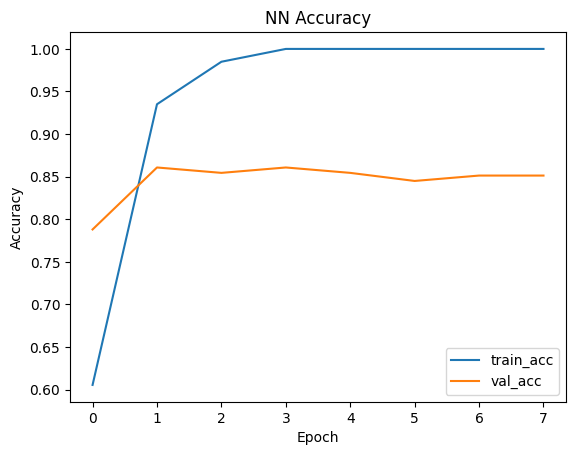

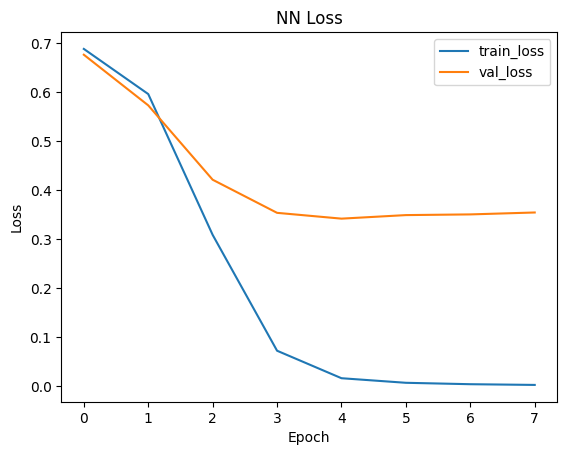

In [16]:
input_dim = X_train_vec.shape[1]

nn = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')

hist = nn.fit(
    X_train_vec.toarray(), y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[es],
    verbose=0
)

y_pred_nn_prob = nn.predict(X_test_vec.toarray()).ravel()
y_pred_nn = (y_pred_nn_prob >= 0.5).astype(int)

acc_nn = accuracy_score(y_test, y_pred_nn)
prec_nn, rec_nn, f1_nn, _ = precision_recall_fscore_support(y_test, y_pred_nn, average='binary')

print(f"NN — Accuracy: {acc_nn:.4f}, Precision: {prec_nn:.4f}, Recall: {rec_nn:.4f}, F1: {f1_nn:.4f}")
print('\nClassification Report (NN):\n', classification_report(y_test, y_pred_nn, digits=4))

cm_nn = confusion_matrix(y_test, y_pred_nn)
print('Confusion Matrix (NN):\n', cm_nn)

# Plot training curves
plt.figure()
plt.plot(hist.history['accuracy'], label='train_acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.title('NN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('NN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 8. Results & Comparison

We tabulate core metrics to compare models and record the winner.


In [17]:
summary = pd.DataFrame({
    'model': ['Logistic Regression', 'Neural Network'],
    'accuracy': [acc_lr, acc_nn],
    'precision': [prec_lr, prec_nn],
    'recall': [rec_lr, rec_nn],
    'f1': [f1_lr, f1_nn]
}).sort_values('f1', ascending=False).reset_index(drop=True)

display(summary)

winner = summary.iloc[0]['model']
print(f"[RESULT] Best model: {winner} (by F1 score)")


,model,accuracy,precision,recall,f1
0,Neural Network,0.850633,0.834146,0.872449,0.852868
1,Logistic Regression,0.835443,0.839378,0.826531,0.832905


[RESULT] Best model: Neural Network (by F1 score)


## 9. Takeaways

- With limited or moderately sized datasets and **sparse TF‑IDF features**, linear models
  like **Logistic Regression** can **match or outperform** small neural networks.
- **Regularization** and a **small hyperparameter search** are often sufficient for strong baselines.
- For further gains, consider: character n‑grams, class-weighting, threshold tuning, and
  pre-trained embeddings (e.g., spaCy, fastText) or transformer-based encoders when data permits.


## 10. Reproducibility & How to Run

1. Place your dataset as `book_reviews.csv` or set an env var:
   ```bash
   export BOOK_REVIEW_DATA_PATH=/path/to/your.csv
   ```
2. Install dependencies:
   ```bash
   pip install -r requirements.txt
   ```
3. Run this notebook cell-by-cell.

> Expected columns: `Review` (text), `PositiveReview` (0/1).
